# Identifying influential nodes in social networks via community structure and influence distribution difference

People - Zufan Zhanga, Xieliang Lia, Chenquan Gana


Link = https://doi.org/10.1016/j.dcan.2020.04.011

In [108]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import copy

In [2]:
cora = nx.read_edgelist("./dataset/cora/cora.cites")
num_nodes = cora.number_of_nodes()
num_edges = cora.number_of_edges()
num_nodes, num_edges

(2708, 5278)

In [3]:
def neighbors(G, idx):
    return list(dict(G.adjacency())[str(int(idx))])

def len_second_neighbors(G, idx, neighbor_list=None):
    if neighbor_list is None:
        neighbor_list = neighbors(G, idx)
    l = []
    for t in neighbor_list:
        l += neighbors(t)
    if str(idx) in l:
        return len(l) - 1
    else:
        return len(l)

def common_neighbor(G, u, v):
    nb_u = neighbors(G, u)
    nb_v = neighbors(G, v)
    common_nb = [nb for nb in nb_u if nb in nb_v]
    return common_nb

In [4]:
# Section 5.3 : Parameters
size_seed_nodes = 50
p_bar = 0.1

# # =================================================
# #       Equation 17 : Influence Probability
# # =================================================
# # Takes around 45 mins on single core 2.3Ghz
# # Do not forget to save

# p_uv = np.zeros((num_nodes, num_nodes))
# progress_bar = tqdm(total=(num_nodes * num_nodes))
# for i, u in enumerate(cora.nodes()):
#     for j, v in enumerate(cora.nodes()):
#         if u == v: break
#         num1 = len(common_neighbor(cora, u, v))
#         num2 = (len(neighbors(cora, u)) - 1)
#         den1 = (len(neighbors(cora, u)) + len(neighbors(cora, v)))
#         den2 = (len(neighbors(cora, v)) - 1)
#         if den2 == 0:
#             p_uv[i, j] = p_bar * 2 * num1 * num2 / den1
#         else:
#             p_uv[i, j] = p_bar * 2 * num1 * num2 / (den1 * den2)

#         if num2 == 0:
#             p_uv[j, i] = p_bar * 2 * num1 * den2 / den1
#         else:
#             p_uv[j, i] = p_bar * 2 * num1 * den2 / (den1 * num2)
#     progress_bar.update(num_nodes)
# progress_bar.close()

# # Sanity Check of no NaN value
# np.isnan(p_uv).any()

# # Save to npy file
# np.save('p_uv', p_uv)

# Load Saved npy file
p_uv = np.load('p_uv.npy')
print("p_uv shape:", p_uv.shape)

p_uv shape: (2708, 2708)


In [31]:
# Network Embeddings
# Using DeepWalk
# Link: https://github.com/phanein/deepwalk

# Number of nodes: 2708
# Number of walks: 27080
# Data size (walks*length): 1083200
#
# Settings:
# number of walks; 10 per node
# walk length: 40 from each node
# window size skipgram model: 5
# random seed: 0
# undirected: True
# workers: 4
# representation-size: 64

net_emb = {}
with open('./cora.embeddings', 'r') as emb_file:
    lns = emb_file.readlines()
    for i, ln in enumerate(lns):
        if i == 0: continue
        idx, emb = ln.split(' ', 1)
        emb_array = np.zeros(shape=(64))
        for j, t in enumerate(emb.split(' ')):
            emb_array[j] = float(t)
        net_emb[str(idx)] = emb_array

emb_mat = np.zeros((num_nodes, 64))
for i, emb in enumerate(net_emb.items()):
    emb_mat[i, :] = emb[1]

emb_keys = list(net_emb.keys())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [92]:
# Equation 3
# Modularity Q

def modularity(G, labels, num_clusters):
    degrees = G.degree()
    num_edges = G.number_of_edges()
    Q = 0
    for i in range(1, num_clusters):
        same_cluster_elems = np.where(labels == i)[0]
        pbar = tqdm(total=len(same_cluster_elems) ** 2)
        for i, elem1 in enumerate(same_cluster_elems):
            for j, elem2 in enumerate(same_cluster_elems):
                if i == j: break
                nb_2 = neighbors(G, emb_keys[elem2])
                e_uv = 1 if elem1 in nb_2 else 0
                Q += e_uv - degrees[emb_keys[elem1]] * degrees[emb_keys[elem2]] / (2 * num_edges)
            pbar.update(len(same_cluster_elems))
        pbar.close()
    return Q / num_edges

100%|██████████| 16900/16900 [00:01<00:00, 16157.41it/s]


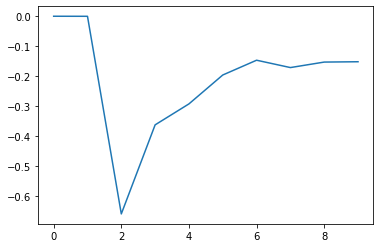

In [94]:
# Section 3.2
# Finding best community structure based on modularity

max_num_clusters = 10
Q_array = []
for num_clusters in range(1, max_num_clusters + 1):
    knn = KMeans(random_state=1001, n_clusters=num_clusters)
    labels = knn.fit_predict(emb_mat)
    labels = labels.reshape(-1, 1)
    Q_array.append(modularity(cora, labels, num_clusters))

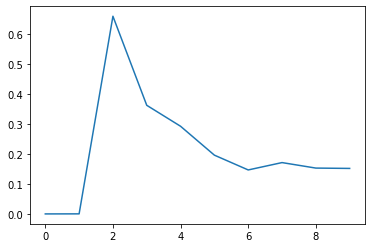

In [98]:
plt.plot(Q_array)
plt.show()

In [99]:
best_num_clusters = 5
knn = KMeans(random_state=1001, n_clusters=best_num_clusters)
labels = knn.fit_predict(emb_mat)
labels = labels.reshape(-1, 1)

In [109]:
LeaderRank = np.ones(num_nodes + 1)
LeaderRank[num_nodes] = 0

newG = copy.deepcopy(cora)
newG.add_node('0')
for node in newG.nodes():
    newG.add_edge('0', node)

error = 10000
error_threshold = 2e-3
step = 1
max_steps = 300

while True:
    tempLR = np.copy(LeaderRank)
    for i, node_i in enumerate(newG.nodes()):
        for j, node_j in enumerate(newG.neighbors(node_i)):
            tempLR[i] += LeaderRank[j] / newG.degree(node_j)

    error = np.sum(np.abs(tempLR - LeaderRank)) / np.sum(tempLR)
    print("Step:", step, ", error:", error)
    LeaderRank = np.copy(tempLR)
    if error <= error_threshold:
        print("Below Error Threshold")
        break
    step = step + 1
    
    if step > max_steps:
        print("Max Steps Reached")
        break

Step: 1 , error: 0.5000922339051839
Step: 2 , error: 0.7777270248431244
Step: 3 , error: 0.6874812940016292
Step: 4 , error: 0.6202005958088093
Step: 5 , error: 0.5799619846916555
Step: 6 , error: 0.5564186865554978
Step: 7 , error: 0.5427053586899423
Step: 8 , error: 0.5347610268831255
Step: 9 , error: 0.5301928893205078
Step: 10 , error: 0.527587255650445
Step: 11 , error: 0.5261119179511272
Step: 12 , error: 0.5252813052786633
Step: 13 , error: 0.5248152724990659
Step: 14 , error: 0.5245540166844013
Step: 15 , error: 0.5244072872554253
Step: 16 , error: 0.5243245095634353
Step: 17 , error: 0.5242774879069004
Step: 18 , error: 0.5242505386435902
Step: 19 , error: 0.524234931976294
Step: 20 , error: 0.5242257913809297
Step: 21 , error: 0.5242203756728538
Step: 22 , error: 0.5242171306348641
Step: 23 , error: 0.5242151657539889
Step: 24 , error: 0.5242139647717384
Step: 25 , error: 0.5242132246872857
Step: 26 , error: 0.5242127654736356
Step: 27 , error: 0.5242124789192538
Step: 28 , e

Step: 224 , error: 0.5242119917447138
Step: 225 , error: 0.5242119917447131
Step: 226 , error: 0.5242119917447131
Step: 227 , error: 0.5242119917447126
Step: 228 , error: 0.524211991744714
Step: 229 , error: 0.5242119917447132
Step: 230 , error: 0.5242119917447134
Step: 231 , error: 0.5242119917447131
Step: 232 , error: 0.5242119917447133
Step: 233 , error: 0.5242119917447138
Step: 234 , error: 0.5242119917447137
Step: 235 , error: 0.5242119917447142
Step: 236 , error: 0.5242119917447122
Step: 237 , error: 0.5242119917447138
Step: 238 , error: 0.5242119917447133
Step: 239 , error: 0.5242119917447124
Step: 240 , error: 0.5242119917447143
Step: 241 , error: 0.5242119917447126
Step: 242 , error: 0.5242119917447141
Step: 243 , error: 0.5242119917447132
Step: 244 , error: 0.524211991744713
Step: 245 , error: 0.5242119917447137
Step: 246 , error: 0.524211991744713
Step: 247 , error: 0.5242119917447136
Step: 248 , error: 0.5242119917447137
Step: 249 , error: 0.5242119917447128
Step: 250 , err

In [113]:
LeaderRank = LeaderRank + LeaderRank[-1] / num_edges

In [114]:
LeaderRank = LeaderRank[:-1] # Pop ground node

In [118]:
LeaderRank = LeaderRank / np.sum(LeaderRank)